In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa
import cv2

In [10]:
data = pd.read_csv('data/birdclef-2021/train_metadata.csv')
#data

In [11]:
import IPython.display as ipd

audio_path = 'data/birdclef-2021/train_short_audio/banana/XC4311.ogg'
sig, rate = librosa.load(audio_path, sr=None, offset=None, duration=None)

ipd.Audio(audio_path)

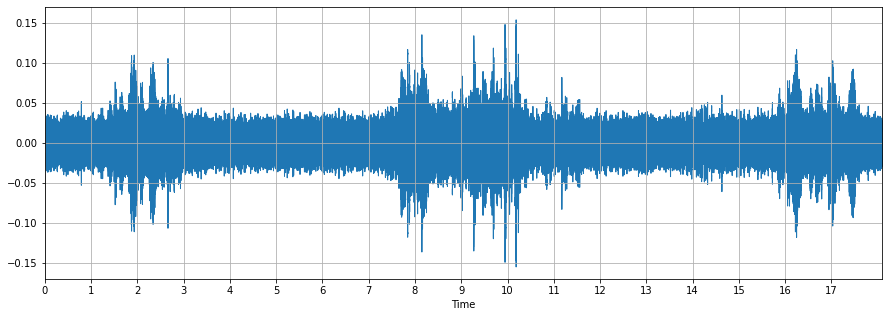

In [12]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(sig, sr = rate)
plt.xticks(range(18))
plt.grid('on')
plt.show()


In [13]:
import scipy.signal as signal
print("Total STD: %.4f" % sig.std())
DURATION = 2
for second in [5,10,18]:
    s_start = int((second - DURATION) * SAMPLE_RATE)
    s_end = int(second * SAMPLE_RATE)
    print("STD: %.4f" % sig[s_start:s_end].std())
    plt.plot(sig[s_start:s_end])
    plt.show()


Total STD: 0.0158


NameError: name 'SAMPLE_RATE' is not defined

0.20046281814575195


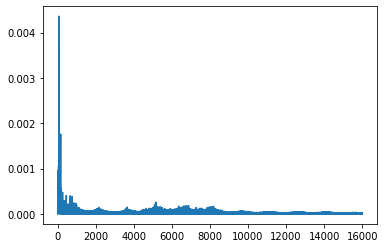

In [106]:
t0 = time()
T = 1/rate
N = len(sig)
xf = np.fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0 / N * np.abs(np.fft.fft(sig))[:N//2])
print(time() - t0)

In [62]:
def melspec(sig, rate, shape=(64, 256), fmin=500, fmax=15000, normalize=True, preemphasis=0.95):
    # Mel-Spec parameters
    SAMPLE_RATE = rate
    N_FFT = shape[0] * 8 # = window length
    N_MELS = shape[0]
    HOP_LEN = len(sig) // (shape[1] - 1)    
    FMAX = fmax
    FMIN = fmin

    # Preemphasis as in python_speech_features by James Lyons
    if preemphasis:
        sig = np.append(sig[0], sig[1:] - preemphasis * sig[:-1])

    # Librosa mel-spectrum
    melspec = librosa.feature.melspectrogram(y=sig, sr=SAMPLE_RATE, hop_length=HOP_LEN, n_fft=N_FFT, n_mels=N_MELS, fmax=FMAX, fmin=FMIN, power=1.0)
    
    # Convert power spec to dB scale (compute dB relative to peak power)
    melspec = librosa.amplitude_to_db(melspec, ref=np.max, top_db=80)

    # Flip spectrum vertically (only for better visialization, low freq. at bottom)
    melspec = melspec[::-1, ...]

    # Trim to desired shape if too large
    melspec = melspec[:shape[0], :shape[1]]

    # Normalize values between 0 and 1
    if normalize:
        melspec -= melspec.min()
        if not melspec.max() == 0:
            melspec /= melspec.max()
        else:
            mlspec = np.clip(melspec, 0, 1)

    return melspec.astype('float32')

def get_path(row_index):
    return 'data/birdclef-2021/train_short_audio/' + data.loc[0].primary_label + '/' + data.loc[0].filename
def signaltonoise(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return sd
    return np.where(sd == 0, 0, m/sd)

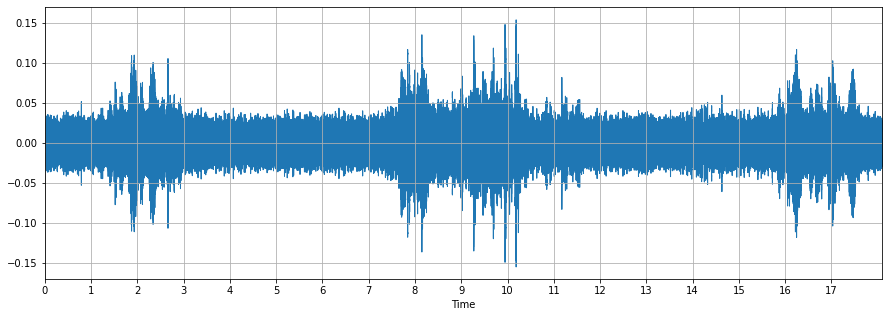

In [15]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(sig, sr = rate)
plt.xticks(range(18))
plt.grid('on')
plt.show()


2048
(64, 256)
Signal to noise ratio = 0.0531005859


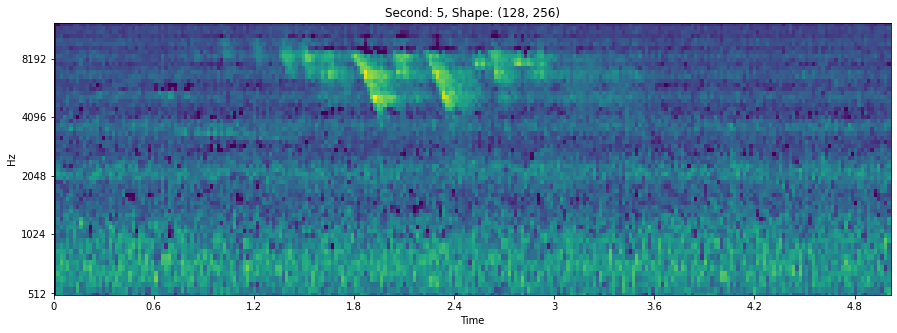

(64, 256)
Signal to noise ratio = 0.0547485352


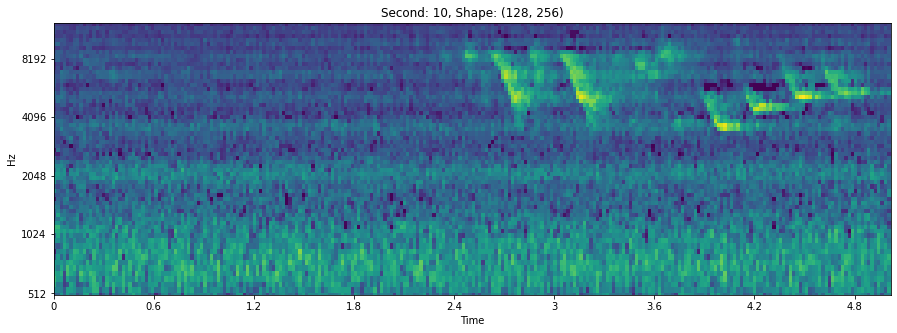

(64, 256)
Signal to noise ratio = 0.0004272461


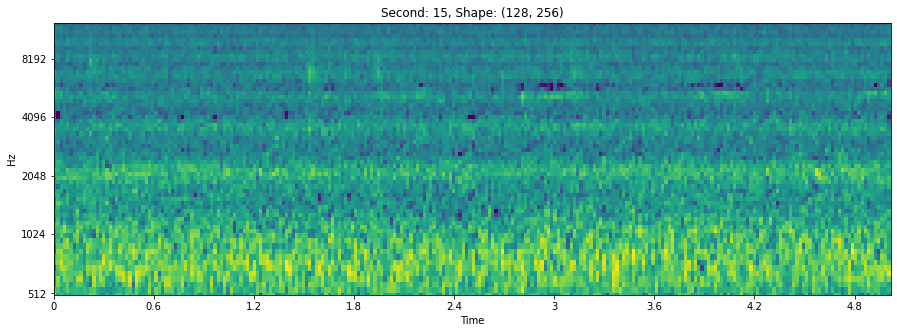

In [64]:
def signal2noise(spec):

    # Get working copy
    spec = spec.copy()

    # Calculate median for columns and rows
    col_median = np.median(spec, axis=0, keepdims=True)
    row_median = np.median(spec, axis=1, keepdims=True)

    # Binary threshold
    spec[spec < row_median * 1.25] = 0.0
    spec[spec < col_median * 1.15] = 0.0
    spec[spec > 0] = 1.0

    # Median blur
    spec = cv2.medianBlur(spec, 3)

    # Morphology
    spec = cv2.morphologyEx(spec, cv2.MORPH_CLOSE, np.ones((3, 3), np.float32))

    # Sum of all values
    spec_sum = spec.sum()

    # Signal to noise ratio (higher is better)
    try:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1] * spec.shape[2])
    except:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1])

    return s2n


from librosa.feature import melspectrogram

DURATION = 5
SAMPLE_RATE = 32000
SPEC_HEIGHT = 64
SPEC_WIDTH = 256
NUM_MELS = SPEC_HEIGHT
HOP_LENGTH = int(SAMPLE_RATE * DURATION / (SPEC_WIDTH - 1)) # sample rate * duration / spec width - 1 == 627
FMIN = 500
FMAX = 12500
N_FFT = SPEC_WIDTH * 8
print(N_FFT)
for second in [5,10,15]:
    s_start = (second - DURATION) * SAMPLE_RATE
    s_end = second * SAMPLE_RATE

    mel_spec = librosa.feature.melspectrogram(y=sig[s_start:s_end], 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=HOP_LENGTH, 
                                              n_mels=NUM_MELS, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    print(mel_spec.shape)

    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max, top_db=80)
    if True:
        mel_spec_db -= mel_spec_db.min()
        if not mel_spec_db.max() == 0:
            mel_spec_db /= mel_spec_db.max()
            
    print("Signal to noise ratio = %.10f" % signal2noise(mel_spec_db))
    
    plt.figure(figsize=(15, 5))
    plt.title('Second: ' + str(second) + ', Shape: ' + str(spec.shape))

    librosa.display.specshow(mel_spec_db, 
                             sr=32000, 
                             hop_length=HOP_LENGTH, 
                             x_axis='time', 
                             y_axis='mel',
                             fmin=FMIN, 
                             fmax=FMAX, 
                             cmap=plt.get_cmap('viridis'))
    plt.show()

0.0139617919921875


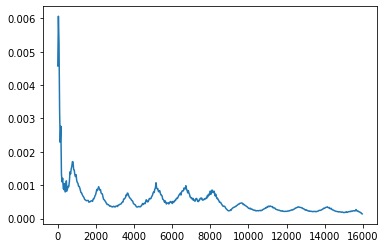

In [24]:
from time import time
import librosa

audio_path = 'data/birdclef-2021/train_short_audio/banana/XC4311.ogg'
sig, rate = librosa.load(audio_path, sr=None, offset=None, duration=None)
t0 = time()

tot_len = len(sig)
samples_len = 1000

samples = tot_len // samples_len

T = 1/rate
xf = np.fft.fftfreq(samples_len, T)[:samples_len//2]

yf = np.zeros(len(xf))

for i in range(samples):
    curr_sig = sig[samples_len*i:samples_len*(i+1)]
    yf += 2.0 / samples_len * np.abs(np.fft.fft(curr_sig)[:samples_len//2])
print(time() - t0)
yf = yf / samples
plt.plot(xf, yf)

In [147]:
from time import time
t0 = time()
for i in range(100):
    mel_spec = librosa.feature.melspectrogram(y=sig[s_start:s_end], 
                                              sr=32000, 
                                              n_fft=1024, 
                                              hop_length=HOP_LENGTH, 
                                              n_mels=NUM_MELS, 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
print(time() - t0)

0.4228789806365967


In [1]:
import create_data
import cv2
import librosa
from matplotlib import pyplot as plt
from librosa.display import waveplot


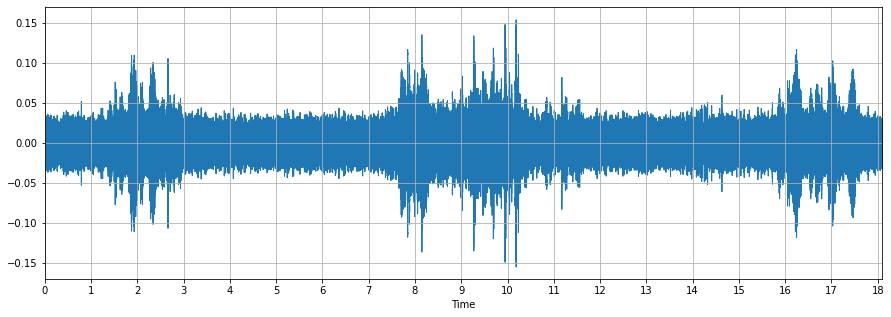

In [3]:
audio_path = 'data/birdclef-2021/train_short_audio/banana/XC4311.ogg'

sig, rate = librosa.load(audio_path, sr=None, offset=None, duration=None)
plt.figure(figsize=(15, 5))
plt.grid('on')
librosa.display.waveplot(sig, sr = rate)
plt.xticks(range(19))
plt.show()

In [ ]:
seconds = 1
overlap = 0

for i, spec in enumerate(create_data.specs_from_file(audio_path, seconds, overlap, n_fft = 1024)):
    start = i*(seconds-overlap)
    end = i*(seconds-overlap) + seconds
    print("Start = %d, end = %d, SNR = %s" % (start, end, create_data.signal2noise(spec)), end = '\r')
    cv2.imshow("a", spec)
    cv2.waitKey(0)
    cv2.destroyAllWindows()